<a href="https://colab.research.google.com/github/ngockhanh5110/nlp-vietnamese-text-summarization/blob/main/notebooks/inferencing_vietnews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Overview: The code below is for the purpose of comparing the quality of the algorithms Lsa, KL, LexRank, TextRank, SumBasic, Luhn with the model I trained**

# **Connect to drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Install lib**

In [ ]:
!pip install vncorenlp datasets==1.0.2
!pip install transformers
!pip install dill==0.3.5.1



In [ ]:
!pip install git-python==1.0.3
# !pip install sacrebleu==1.4.12
!pip install rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=3ee39b02856234b476199a225256c70a626d83dd3103a382a87c5b4b5c0a7f51
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [ ]:
import os
new_path = "/content/drive/MyDrive/LLM_TEXT/"
os.chdir(new_path)
current_path = os.getcwd()
print("current path:", current_path)

current path: /content/drive/MyDrive/LLM_TEXT


In [ ]:
import glob
import pandas as pd
import concurrent.futures
from datasets import *
import datasets
import transformers
import nltk
nltk.download('punkt')

from transformers import RobertaTokenizerFast,AutoTokenizer
from seq2seq_trainer import Seq2SeqTrainer
from transformers import TrainingArguments
from dataclasses import dataclass, field
from typing import Optional

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
!pip install sumy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.3/97.3 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 37.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21693 sha256=b93219b0df15e8c8b0c6313a3500dab5f0453cf6c57f95675512b95ff2b60667
  Stored in directory: /root/.cache/pip/wheels/64/22/90/b84fcc30e16598db20a0d41340616dbf9b1e82bbcc627b0b33
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=c02b67d56c54f46fe02e559ec4ae6f04c52a263d4ff51312bdd5632d56e3fa1f
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=1068

# **Processing data**

In [ ]:
size_data_test = 10

summary_task_original_new = []

In [ ]:
# Đọc danh sách các file từ đường dẫn được cung cấp
def listPaths(path):
  pathfiles = list()
  cnt = 0
  for pathfile in glob.glob(path):
    cnt += 1
    pathfiles.append(pathfile)
    if cnt == size_data_test:
       break
  return pathfiles

test_paths = listPaths('/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/*.txt')
for file in test_paths:
  print(file)

/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/02.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/04.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/10.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/11.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/13.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/14.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/15.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/19.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/03.txt
/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/08.txt


In [ ]:
# Đọc nội dung file
def read_content(path_file):
  """
  Input: Path of txt file
  Output
  """
  # print("\n\n path_file:", path_file)
  summary_content = ""
  summary_task = ""
  original = ""
  summary_taskDict = []
  with open(path_file, "r", encoding="utf-8") as file:
      lines  = file.readlines()
      cnt = 0
      # print("\n\n path_file:",path_file)
      # print("\n\n lines:",lines)
      for line in lines:
          line = line.strip()

          if "NOI_DUNG_TOM_TAT" in line:
              cnt = 1
              line = line.replace("NOI_DUNG_TOM_TAT", "")
              line = line.replace(":", "")
          elif "NHIEM_VU" in line:#line.startswith("NHIEM_VU"):
              cnt = 2
              line = line.replace("NHIEM_VU", "")
              line = line.replace(":", "")
          # new code
          elif "NGUOI_LAM" in line: #line.startswith("NGUOI_LAM"):
              summary_taskDict.append({ "people": "", "content": "", "time": ""})
              cnt = 20
              line = line.replace("NGUOI_LAM", "")
              line = line.replace(":", "")
          elif "NOI_DUNG_CV" in line: #line.startswith("NOI_DUNG_CV"):
              cnt = 21
              line = line.replace("NOI_DUNG_CV", "")
              line = line.replace(":", "")
          elif "THOI_GIAN" in line: #line.startswith("THOI_GIAN"):
              cnt = 22
              line = line.replace("THOI_GIAN", "")
              line = line.replace(":", "")
          #end
          elif "NOI_DUNG_GOC" in line: #line.startswith("NOI_DUNG_GOC"):
              cnt = 3
              line = line.replace("NOI_DUNG_GOC", "")
              line = line.replace(":", "")

          line += " "
          # line  = line.replace("..", ". ")
          if line:
            if cnt == 1:
              summary_content += line
            #elif cnt == 2:
            #  summary_task += line
            elif cnt == 20:
              summary_taskDict[-1]["people"] += line
            elif cnt == 21:
              summary_taskDict[-1]["content"] += line
            elif cnt == 22:
              summary_taskDict[-1]["time"] += line

            elif cnt == 3:
              original += line

  # print("summary_content:", summary_content)
  # print("summary_task:", summary_task)
  # print("original:", original)
  summary_task_original_new.append({'file' : path_file,
          'summary_task': summary_taskDict})

  return {'file' : path_file,
          # 'summary_task': summary_taskDict,
          'summary_content': summary_content,
          'original': original}

In [ ]:
# Đọc các key word
def get_stop_words_vn(path):
    ret = []
    # path = "/content/drive/MyDrive/LLM_TEXT/vietnamese-stopwords-dash.txt"
    f = open(path, "r")
    lines = f.readlines()
    for line  in lines:
       line = line.replace("_", " ")
       line = " " + line.replace("\n", "") + " "
       ret.append(line)
    return ret

stop_words = get_stop_words_vn("/content/drive/MyDrive/LLM_TEXT/vietnamese-stopwords-dash.txt")
task_words = get_stop_words_vn("/content/drive/MyDrive/LLM_TEXT/vietnamese-task-dash.txt")
time_words = get_stop_words_vn("/content/drive/MyDrive/LLM_TEXT/vietnamese-task-time.txt")
print("time_words", time_words)
print("task_words", task_words)

time_words [' deadline ']
task_words [' nhiệm vụ ', ' đảm nhiệm vai trò ', ' đảm nhận vai trò ', ' đảm nhận công việc ', ' đảm nhiệm nhiệm vụ ', ' được phân công việc ', ' được giao công việc ', ' đã giao cho ', ' phụ trách công việc ', ' sẽ giao công việc ', ' sẽ phân công việc ', ' phân công công việc ', ' sẽ tiến hành ', ' đảm nhận ']


## **Get data**

In [ ]:
def get_dataframe(pathfiles):
  with concurrent.futures.ProcessPoolExecutor() as executor:
    data = executor.map(read_content, pathfiles)

  # Make blank dataframe
  data_df = list()
  for d in data:
    data_df.append(d)
  data_df = pd.DataFrame(data_df)
  data_df.dropna(inplace = True)
  data_df = data_df.sample(frac=1).reset_index(drop=True)

  return data_df

In [ ]:

test_df = get_dataframe(test_paths)
print ("test_df", test_df["summary_content"] )

summary_task_original_new = []
for path_file in test_df["file"]:
  read_content(path_file)

for task in summary_task_original_new:
  print ("task", task )

test_df 0    ﻿ Vào hồi 16 giờ ngày 22 tháng 8 năm 2021  diễ...
1    ﻿ Lớp 11A3 tổ chức cuộc họp năm khen thưởng độ...
2     Gia đình Tuyến tổ chức cuộc họp nhằm tìm các ...
3     Trong cuộc họp giao nhiệm vụ của công ty Vạn ...
4    ﻿ Cuộc họp diễn ra tại công ty Vạn Thắng nhằm ...
5     ban chi uỷ chi bộ Minh Dương tổ chức cuộc   h...
6     Công ty Nam Khánh  diễn ra cuộc họp quan trọn...
7     Gia đình ông Nguyễn Văn Tùng tổ chức cuộc họp...
8     Vào 7 giờ 15 phút ngày 24 tháng 6 năm 2023 , ...
9     Ban chỉ đạo trường THCS Hồng Thái họp bàn về ...
Name: summary_content, dtype: object
task {'file': '/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/11.txt', 'summary_task': [{'people': ' Lan ', 'content': ' đảm nhận đánh giá trong tháng 8 của ban BCH công đoàn và triển khai nhiệm vụ tháng 9 của UBKT ', 'time': ' Deadline 22 tháng 8, 2021  '}, {'people': ' Hương ', 'content': ' đảm nhận  kiểm tra, giám sát việc thực hiện điều lệ, kế hoạch, nghị quyết của CĐCS ', 'time': ' Deadline 22 tháng

In [ ]:
test_data =  Dataset.from_pandas(test_df)

NameError: ignored

In [ ]:
# load rouge for validation
rouge = datasets.load_metric("rouge")

# **Summary content with LDA**

In [ ]:
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess

In [ ]:


# Ví dụ dữ liệu không gán nhãn về nội dung công việc và nội dung giao việc
data = [
    "Nội dung công việc.",
    "Nội dung giao việc.",
    # Thêm các đoạn văn bản khác tại đây
]

# Tiền xử lý dữ liệu
def preprocess_text(text):
    return simple_preprocess(text, deacc=True)

processed_data = [preprocess_text(text) for text in data]

# Xây dựng từ điển từ vựng
dictionary = corpora.Dictionary(processed_data)

# Chuyển đổi văn bản thành bag-of-words representation
corpus = [dictionary.doc2bow(text) for text in processed_data]

# Xác định số lượng chủ đề (cluster)
num_topics = 1  # Số lượng chủ đề bạn muốn phân cụm, ở đây chúng ta chọn 1 chủ đề

# Xây dựng mô hình LDA
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)

# In ra các chủ đề đã phân cụm
for idx, topic in lda_model.print_topics():
    print(f"Chủ đề {idx + 1}: {topic}")

# Phân loại đoạn văn bản mới vào các chủ đề
new_text = '''nội dung công việc'''
new_processed_text = preprocess_text(new_text)
new_bow = dictionary.doc2bow(new_processed_text)
new_topic = lda_model[new_bow]
print("Đoạn văn bản mới thuộc chủ đề:", new_topic)

Chủ đề 1: 0.231*"dung" + 0.231*"noi" + 0.231*"viec" + 0.154*"cong" + 0.154*"giao"
Đoạn văn bản mới thuộc chủ đề: [(0, 1.0)]


In [ ]:
!pip install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import sent_tokenize

# Đoạn văn bản cần tách nhiệm vụ
text = """
Hôm nay ngày 21 tháng 4 năm 2023 tại trường THCS kim Liên diễn ra cuộc họp của ban trung tâm bàn nội dung công việc và nhiệm vụ thực hiện của tháng 5. Cuộc họp có 6 thành viên đó là các đồng chí: Oanh, Tâm, Hường, Quỳnh, Xuân, Hoa.
Đồng chí Nguyễn Kim Oanh hiệu trưởng nhà trường điều hành cuộc họp đã nêu nội dung công việc thực hiện trong tháng và phân công công việc cụ thể cho từng thành viên. Dưới đây là phần phân công công việc cụ thể và thời gian cho từng
người: Đồng chí Tâm sẽ tham dự các chuyên đề do cụm, huyện tổ chức, triển khai lại chuyên đề đã dự tới các giáo viên. Tổ chức cho GV và HS lớp 3, 4 và 5 giao lưu “ATGT cho nụ cười trẻ thơ” năm học 2020-2021, làm báo cáo gửi PGD và
hoàn thành học Module 3 chương trình GDPT 2018. Deadline: 12 tháng 5 năm 2023. Đồng chí Hường nhận nhiệm vụ vận động CĐV tích cực thực hiện chỉ thị số 19- CT/TU ngày 19/10/2018 của Ban Thường vụ Thành ủy về thực hiện cuộc vận động “Người dân thành
phố không xả rác ra đường và kênh rạch vì thành phố sạch và giảm ngập nước” tạo môi trường xanh, sạch, đẹp, vận động CĐV tham gia đóng góp quỹ Vì biển đảo quê hương và vì tuyến đầu Tổ quốc. Deadline: 12 tháng 5 năm 2023. Đồng chí
Quỳnh nhận nhiệm vụ sẽ tuyên truyền giáo dục An toàn giao thông cho học sinh vào các giờ chào cờ đầu tuần.Tham gia và thực hiện các hoạt động đội theo kế hoạch của quận. Deadline: 12 tháng 5 năm 2023. Đồng chí Xuân nhận nhiệm vụ hoàn tất báo cáo y tế và nộp về
trung tâm y tế , tuyên truyền cho học sinh phòng chống dịch bệnh covid-19, sốt xuất huyết, tay chân miệng, .... . Deadline: 12 tháng 5 năm 2023. Đồng chí Hoa sẽ cập nhật phần mềm thu chi và thực hiện cập nhật các khoản thu, chi, thực
hiện thu các khoản thu tại đơn vị: đồng phục HS, bơi, tiền  trường, BHYT, BHTN, nộp nhận giấy chứng nhận HTCTTH. Deadline: 12 tháng 5 năm 2023. Thời gian để các đồng chí thực hiện nhiệm vụ bắt đầu từ hôm nay ngày 21 tháng 4 năm 2023
đến ngày 12 tháng 5 năm 2023. Rất mong các đồng chí tập chungcố gắng hoàn thành tốt nhiệm vụ được giao dung quy định. Cuộc họp kết thúc với 100% ý kiến tán thành.
"""

# Tách thành các câu
sentences = sent_tokenize(text)

# Tiền xử lý dữ liệu
def preprocess_text(text):
    return text.lower().split()

preprocessed_sentences = [preprocess_text(sentence) for sentence in sentences]

# Tạo từ điển cho LDA
dictionary = corpora.Dictionary(preprocessed_sentences)

# Tạo corpus (biểu diễn các câu thành dạng vector)
corpus = [dictionary.doc2bow(sentence) for sentence in preprocessed_sentences]

# Sử dụng LDA để tách nhiệm vụ
num_topics = 4
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=20)

# Hiển thị kết quả tách nhiệm vụ
print("step 1")
for i, sentence in enumerate(sentences):
    topic_id = lda_model[dictionary.doc2bow(preprocess_text(sentence))][0][0]
    print(f"Đoạn văn {i+1} thuộc nhiệm vụ số {topic_id + 1}: {sentence}")



step 1
Đoạn văn 1 thuộc nhiệm vụ số 2: 
Hôm nay ngày 21 tháng 4 năm 2023 tại trường THCS kim Liên diễn ra cuộc họp của ban trung tâm bàn nội dung công việc và nhiệm vụ thực hiện của tháng 5.
Đoạn văn 2 thuộc nhiệm vụ số 1: Cuộc họp có 6 thành viên đó là các đồng chí: Oanh, Tâm, Hường, Quỳnh, Xuân, Hoa.
Đoạn văn 3 thuộc nhiệm vụ số 2: Đồng chí Nguyễn Kim Oanh hiệu trưởng nhà trường điều hành cuộc họp đã nêu nội dung công việc thực hiện trong tháng và phân công công việc cụ thể cho từng thành viên.
Đoạn văn 4 thuộc nhiệm vụ số 4: Dưới đây là phần phân công công việc cụ thể và thời gian cho từng
người: Đồng chí Tâm sẽ tham dự các chuyên đề do cụm, huyện tổ chức, triển khai lại chuyên đề đã dự tới các giáo viên.
Đoạn văn 5 thuộc nhiệm vụ số 4: Tổ chức cho GV và HS lớp 3, 4 và 5 giao lưu “ATGT cho nụ cười trẻ thơ” năm học 2020-2021, làm báo cáo gửi PGD và
hoàn thành học Module 3 chương trình GDPT 2018.
Đoạn văn 6 thuộc nhiệm vụ số 1: Deadline: 12 tháng 5 năm 2023.
Đoạn văn 7 thuộc nhiệm vụ 

In [ ]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import sent_tokenize

# Đoạn văn bản cần tách nhiệm vụ
text = """
Trong cuộc họp giao nhiệm vụ của chúng ta, chúng ta đã thảo luận về việc phát triển một trang web quản lý nhà hàng để tăng cường hiệu quả hoạt động của chúng ta. Dưới đây là phân công nhiệm vụ cho ba thành viên trong nhóm:
Thành viên Chi sẽ đảm nhận vai trò chính trong việc phát triển phần giao diện người dùng (UI) của trang web. Nhiệm vụ của anh ta bao gồm: Nghiên cứu và thiết kế giao diện người dùng hợp lý, thân thiện và dễ sử dụng cho trang web quản lý nhà hàng.
Phát triển các trang và chức năng liên quan đến quản lý thực đơn, đặt bàn, và xem thông tin khách hàng. Đảm bảo tính tương thích và phản hồi của giao diện trên nhiều thiết bị và trình duyệt khác nhau. Thành viên Lan sẽ đảm nhiệm nhiệm vụ phát triển phần backend của trang web quản lý nhà hàng.
Các nhiệm vụ cụ thể của anh ta là: Xây dựng cơ sở dữ liệu để lưu trữ thông tin về thực đơn, đặt bàn, và khách hàng. Xây dựng các API để kết nối giao diện người dùng với cơ sở dữ liệu. Xử lý logic xác thực và phân quyền truy cập để đảm bảo tính bảo mật của hệ thống.
Thành viên Chung sẽ đảm nhiệm việc kiểm thử và triển khai trang web quản lý nhà hàng. Các nhiệm vụ cụ thể của anh ta là: Tạo các bộ kiểm tra tự động để đảm bảo tính đúng đắn và ổn định của trang web. Thực hiện kiểm thử chức năng, kiểm tra lỗi và đánh giá hiệu suất để đảm bảo trang web hoạt
động mượt mà và đáp ứng đúng yêu cầu. Triển khai trang web lên môi trường sản xuất và đảm bảo quá trình triển khai suôn sẻ. Chúng ta sẽ thiết lập các cuộc họp định kỳ để theo dõi tiến độ và giải quyết các vấn đề nảy sinh trong quá trình phát triển. Tất cả các thành viên đều được khuyến khích
chia sẻ ý kiến, góp ý và cùng nhau làm việc để hoàn thành dự án một cách thành công và chất lượng cao.

"""

# Tách thành các câu
sentences = sent_tokenize(text)

# Tiền xử lý dữ liệu
def preprocess_text(text):
    return text.lower().split()

preprocessed_sentences = [preprocess_text(sentence) for sentence in sentences]

# Tạo từ điển cho LDA
dictionary = corpora.Dictionary(preprocessed_sentences)

# Tạo corpus (biểu diễn các câu thành dạng vector)
corpus = [dictionary.doc2bow(sentence) for sentence in preprocessed_sentences]

# Sử dụng LDA để tách nhiệm vụ
num_topics = 4
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=20)

# Hiển thị kết quả tách nhiệm vụ
print("step 1")
for i, sentence in enumerate(sentences):
    topic_id = lda_model[dictionary.doc2bow(preprocess_text(sentence))][0][0]
    print(f"Đoạn văn {i+1} thuộc nhiệm vụ số {topic_id + 1}: {sentence}")

step 1
Đoạn văn 1 thuộc nhiệm vụ số 2: 
Trong cuộc họp giao nhiệm vụ của chúng ta, chúng ta đã thảo luận về việc phát triển một trang web quản lý nhà hàng để tăng cường hiệu quả hoạt động của chúng ta.
Đoạn văn 2 thuộc nhiệm vụ số 2: Dưới đây là phân công nhiệm vụ cho ba thành viên trong nhóm:
Thành viên Chi sẽ đảm nhận vai trò chính trong việc phát triển phần giao diện người dùng (UI) của trang web.
Đoạn văn 3 thuộc nhiệm vụ số 1: Nhiệm vụ của anh ta bao gồm: Nghiên cứu và thiết kế giao diện người dùng hợp lý, thân thiện và dễ sử dụng cho trang web quản lý nhà hàng.
Đoạn văn 4 thuộc nhiệm vụ số 1: Phát triển các trang và chức năng liên quan đến quản lý thực đơn, đặt bàn, và xem thông tin khách hàng.
Đoạn văn 5 thuộc nhiệm vụ số 1: Đảm bảo tính tương thích và phản hồi của giao diện trên nhiều thiết bị và trình duyệt khác nhau.
Đoạn văn 6 thuộc nhiệm vụ số 1: Thành viên Lan sẽ đảm nhiệm nhiệm vụ phát triển phần backend của trang web quản lý nhà hàng.
Đoạn văn 7 thuộc nhiệm vụ số 4: Các 

In [3]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import sent_tokenize

def preprocess_text(str):
      return text.lower().split()

def topicGroupLDA(str):
  ret = []
  sentences = sent_tokenize(str)
  preprocessed_sentences = [preprocess_text(sentence) for sentence in sentences]
  dictionary = corpora.Dictionary(preprocessed_sentences)
  corpus = [dictionary.doc2bow(sentence) for sentence in preprocessed_sentences]
  num_topics = 4
  lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=20)
  print("step 1")
  for i, sentence in enumerate(sentences):
    topic_id = lda_model[dictionary.doc2bow(preprocess_text(sentence))][0][0]
    print(f"Đoạn văn {i+1} thuộc nhiệm vụ số {topic_id + 1}: {sentence}")
    ret[topic_id] += sentence

  return ret




## **Summary task**

### **Case 1: Using vnvorenlp**



In [ ]:
!pip install vncorenlp

In [ ]:
import os
from vncorenlp import VnCoreNLP
vncorenlp_folder = '/content/drive/MyDrive/LLM_TEXT/VnCoreNLP-master/'
vncorenlp_file = os.path.join(vncorenlp_folder, 'VnCoreNLP-1.1.1.jar')

vnlp = VnCoreNLP(vncorenlp_file, annotators="wseg,pos,ner")

In [ ]:
text = "Hôm nay ngày 21 tháng 4 năm 2023 tại trường THCS kim Liên diễn ra cuộcHôm nay, Mai Anh và Hải Đăng đã đến thăm chị Lan tại Hà Nội. họp của ban trung tâm bàn nội "
def getName(str):
  annotated_text = vnlp.annotate(str)
  person_entities = []
  for sentence in annotated_text['sentences']:
      for entity in sentence:
          if entity["nerLabel"] == 'B-PER':
              person_entities.append(entity["form"])
  return person_entities

print(getName(text))

['Mai_Anh', 'Hải_Đăng', 'Lan']


### **Case 2: Pre-train model (PhoBERT)**

In [ ]:
import datasets
from transformers import RobertaTokenizer, EncoderDecoderModel, AutoTokenizer
from sklearn.model_selection import train_test_split


tokenizerName = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

modelName = EncoderDecoderModel.from_pretrained('/content/drive/MyDrive/LLM_TEXT/trainning_Name/checkpoint-8000')
modelName.to("cpu")
batch_size = 32  # change to 64 for full evaluation



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']


In [ ]:
# map data correctly
def getNameCase2(strInput):
    ret = []
    inputs = tokenizerName(strInput, padding="max_length", truncation=True, max_length=256, return_tensors="pt")
    input_ids = inputs.input_ids.to("cpu") #cuda
    attention_mask = inputs.attention_mask.to("cpu")
    outputs = modelName.generate(input_ids, attention_mask=attention_mask)
    output_str = tokenizerName.batch_decode(outputs, skip_special_tokens=True)
    for name in output_str:
      if name in strInput:
        ret.append(name)
    return ret

### **Summary Task**

In [ ]:
import nltk
from nltk import sent_tokenize
# nltk.download('punkt')
import re

def contains_digits(input_str):
    digit_pattern = r'\d'
    match = re.search(digit_pattern, input_str)
    return match is not None

def process_content_sentences( body: str, min_length=5, max_length=50):
        # for word in reversed(stop_words):
        #   body.replace(word, " ")
        sents = [s.strip() for s in sent_tokenize(body)]
        return [c for c in sents if max_length > len(c.split(" ")) > min_length]

def detectTask(str, case1 = True):
  sentences = process_content_sentences(str, 1, 400)
  ret = []
  for sentence in sentences:
    sentencelower = sentence.lower()
    time = ""
    for wTime in time_words:
      if wTime.strip() in sentencelower:
          time = sentencelower
          try:
            if contains_digits(time):
              ret[-1]["time"] = time
              # print("time ", time)
          except:
            pass

          break
    for wTask in task_words:
      if wTask.strip() in sentencelower:
        people = []
        if case1:
          people = getName(sentence)
        else:
          people = getNameCase2(sentence)

        ret.append({"people": people, "content": sentencelower, "time": "" })
        break
  return ret

In [ ]:

txt = read_content("/content/drive/MyDrive/LLM_TEXT/dataset/BBCH/05.txt")
print ("Nội dung gốc: ", txt['original'])
test_task = detectTask(txt['original'], False)
cnt_32 = 0
for task in test_task:
  cnt_32 += 1
  print("\n")
  print ("Nhiệm vụ thứ ", cnt_32)
  print("Người làm: ", task['people'])
  print("Nội dung nhiệm vụ: ", task['content'])
  print("thời gian: ", task['time'])

Nội dung gốc:   Vào hồi 15 giờ 30  ngày 23 tháng 02 năm 2023,  tổ chuyên môn số 5 trường tiểu học Kim Liên sinh hoạt chuyên môn họp bàn  xây dựng tiết dạy chuyên đề môn khoa học: Bài Sự sinh sản và nuôi con của chim . Tham gia cuộc họp có 5 giáo viên đó là các đồng chí: Phương, Hà, Hùng, Trà, Tâm.  Đồng chí Phương tổ trưởng điều hành cuộc họp và phân công nhiệm vụ cho từng thành viên. Dưới đây là phân công công việc cho việc xây dựng chuyên đề môn khoa học lớp 5: Bài sự sinh sản và nuôi con của chim . Phương đảm nhận việc nêu chuyên  đề bám sát trong sách giáo khoa  đồng thời có thêm một số  kiến thức mở rộng về việc nuôi con của chim. Deadline: 16 tháng 3, 2023. Hà sẽ đảm nhận tiến hành xây dựng  kế hoạch bài dạy đưa ra các hoạt động  dạy học phù hợp với nội dung của từng yêu cầu mà SGK đề cập đến. Deadline: 16 tháng 3, 2023. Hùng đảm nhận tìm các bản đồ lược  đồ , tranh, thước phim minh hoạ liên quan đến quá trình sinh sản và nuôi con của một số loài chim  liên quan đến các hoạt động

# **Inference**

In [ ]:
path_result = "/content/drive/MyDrive/LLM_TEXT/inference/infer_BBCH/"
RATIO = 0.2
listAlorithms = ['KLSummarizer','LexRankSummarizer','LsaSummarizer','LuhnSummarizer','SumBasicSummarizer','TextRankSummarizer']
models = listAlorithms
rouge1_recall = []
rouge1_precision = []
rouge1_f1 = []
rouge2_recall = []
rouge2_precision = []
rouge2_f1 = []
rougel_recall = []
rougel_precision = []
rougel_f1 = []

In [ ]:
def getRougeMyModel(rouge_output):
   for key,value in rouge_output.items():
      if key == "rouge1":
         rouge1_recall.append(value.mid[0])
         rouge1_precision.append(value.mid[1])
         rouge1_f1.append(value.mid[2])
         print('rouge1:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])
      elif key == "rouge2":
         rouge2_recall.append(value.mid[0])
         rouge2_precision.append(value.mid[1])
         rouge2_f1.append(value.mid[2])
         print('rouge2:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])
      elif key == "rougeL":
         rougel_recall.append(value.mid[0])
         rougel_precision.append(value.mid[1])
         rougel_f1.append(value.mid[2])
         print('rougeL:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])

## **With my model**

In [ ]:
myModelName = 'Custom "Custom PhoBERT"'

In [ ]:
import datasets
from transformers import RobertaTokenizer, EncoderDecoderModel, AutoTokenizer
from sklearn.model_selection import train_test_split


tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

model = EncoderDecoderModel.from_pretrained('/content/drive/MyDrive/LLM_TEXT/training/checkpoint-30000')
model.to("cpu")
batch_size = 32  # change to 64 for full evaluation

# map data correctly
def generate_summary(batch):
    # Tokenizer will automatically set [BOS] <text> [EOS]
    inputs = tokenizer(batch["original"], padding="max_length", truncation=True, max_length=256, return_tensors="pt")
    input_ids = inputs.input_ids.to("cpu")
    attention_mask = inputs.attention_mask.to("cpu")

    outputs = model.generate(input_ids, attention_mask=attention_mask)

    # all special tokens including will be removed
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    batch["pred"] = output_str

    return batch

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']
The following encoder weights were not tied to the decoder ['roberta/pooler']


In [ ]:

results = test_data.map(generate_summary, batched=True, batch_size=batch_size, remove_columns=["original"])

result_summary_content = results["pred"]
summary_content_original = results["summary_content"]

print ("result_summary_content: ",result_summary_content[0] )
print ("file: ",test_data[0]["file"]  )
print ("summary_conten: ",summary_content_original[0] )
print ("original: ",test_data[0]["original"] )

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (32) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

result_summary_content:  Deadline, một trong những trang thương_mại_điện_tử lớn nhất thế_giới, đã thông_báo kế_hoạch phân_vai nhân_sự cho năm 2019. Theo đó, Deadline sẽ là một
file:  /content/drive/MyDrive/LLM_TEXT/dataset/BBCH/03.txt
summary_conten:   Trong cuộc họp giao nhiệm vụ của công ty Vạn Hoa đã quyết định phân công nhiệm vụ code trang web quản lý nhân sự cho năm thành viên trong nhóm.  
original:   Trong cuộc họp giao nhiệm vụ của chúng ta, chúng ta đã quyết định phân công nhiệm vụ code trang web quản lý nhân sự cho năm thành viên trong nhóm. Dưới đây là phân công cụ thể và deadline cho mỗi thành viên: Phương sẽ đảm nhận vai trò chính trong việc thiết kế giao diện người dùng (UI) và trang chủ. Nhiệm vụ của Phương sẽ là thiết kế giao diện người dùng cho trang web quản lý nhân sự, bao gồm trang chủ hiển thị thông tin tổng quan và các thành phần UI cần thiết. Deadline 1 tháng 1, 2023. Anh sẽ được giao các nhiệm vụ sau: xây dựng chức năng quản lý nhân viên. Nhiệm vụ: Phát triển ch

In [ ]:
# Trích xuất nhiệm vụ từ văn bản cuộc họp, sử dụng mô hình Vncorenlp
result_summary_task = []
for data in test_df["original"]:
  ret_task = detectTask(data, True)
  result_summary_task.append(ret_task)
  for task in ret_task:
    print ("task", task)

task {'people': [], 'content': 'trong cuộc họp giao nhiệm vụ của chúng ta, chúng ta đã quyết định phân công nhiệm vụ code trang web quản lý nhân sự cho năm thành viên trong nhóm.', 'time': ''}
task {'people': ['Phương'], 'content': 'dưới đây là phân công cụ thể và deadline cho mỗi thành viên: phương sẽ đảm nhận vai trò chính trong việc thiết kế giao diện người dùng (ui) và trang chủ.', 'time': ''}
task {'people': ['Phương'], 'content': 'nhiệm vụ của phương sẽ là thiết kế giao diện người dùng cho trang web quản lý nhân sự, bao gồm trang chủ hiển thị thông tin tổng quan và các thành phần ui cần thiết.', 'time': 'deadline 1 tháng 1, 2023.'}
task {'people': [], 'content': 'anh sẽ được giao các nhiệm vụ sau: xây dựng chức năng quản lý nhân viên.', 'time': ''}
task {'people': [], 'content': 'nhiệm vụ: phát triển chức năng quản lý nhân viên, bao gồm thêm, xóa, sửa thông tin nhân viên, tìm kiếm và sắp xếp danh sách nhân viên.', 'time': 'deadline 7 tháng 1, 2023.'}
task {'people': ['Linh'], 'co

In [ ]:
# Trích xuất nhiệm vụ từ văn bản cuộc họp, sử dụng model "Custom PhoBERT"
result_summary_task_new = []
for data in test_df["original"]:
  ret_task = detectTask(data, False)
  result_summary_task_new.append(ret_task)
  for task in ret_task:
    print ("task", task)

task {'people': [], 'content': 'trong cuộc họp giao nhiệm vụ của chúng ta, chúng ta đã quyết định phân công nhiệm vụ code trang web quản lý nhân sự cho năm thành viên trong nhóm.', 'time': ''}
task {'people': ['Phương'], 'content': 'dưới đây là phân công cụ thể và deadline cho mỗi thành viên: phương sẽ đảm nhận vai trò chính trong việc thiết kế giao diện người dùng (ui) và trang chủ.', 'time': ''}
task {'people': ['Phương'], 'content': 'nhiệm vụ của phương sẽ là thiết kế giao diện người dùng cho trang web quản lý nhân sự, bao gồm trang chủ hiển thị thông tin tổng quan và các thành phần ui cần thiết.', 'time': 'deadline 1 tháng 1, 2023.'}
task {'people': ['Anh'], 'content': 'anh sẽ được giao các nhiệm vụ sau: xây dựng chức năng quản lý nhân viên.', 'time': ''}
task {'people': [], 'content': 'nhiệm vụ: phát triển chức năng quản lý nhân viên, bao gồm thêm, xóa, sửa thông tin nhân viên, tìm kiếm và sắp xếp danh sách nhân viên.', 'time': 'deadline 7 tháng 1, 2023.'}
task {'people': ['Linh']

## **Inference data with algorithms** [Lsa, KL, LexRank, TextRank, SumBasic, Luhn]

In [ ]:
import os
import re

def write_data(folder, offset, index, content):
  path = folder+"/summary_{:06d}.txt".format(offset+index+1)
  f = open(path, "w")
  f.write(content)
  f.close()

def folderExist(folder_path):
  if not os.path.exists(folder_path):
      os.makedirs(folder_path)

def clean_text(text):
  text = text.replace("\n"," ")
  text = re.sub("\s\s+"," ",text)
  text = text.replace("TP.", "TP")
  text = re.sub("\.\.+",".",text)
  text = re.sub("…",".",text)
  all_number = re.findall("\d*\.\d+",text)
  all_dot = re.findall("[A-Z|Ê|Ư|Ơ|Â|Ă|Đ]\s*\.", text)
  text_dot = re.findall("\.\s+[^A-Z|Ê|Ư|Ơ|Â|Ă|Đ]", text)
  for w in all_number:
    text = text.replace(w, w.replace(".",""))
  for w in all_dot:
    text = text.replace(w, w.replace(".",""))
  for w in text_dot:
    text = text.replace(w, w.replace(".",""))
  text = re.sub(r"[()\"#@:<>{}`+=~|!“”]", "", text)
  print("allnumber:",all_number)
  print("all_dot",all_dot)
  print('text_dot:',text_dot)
  return text

def load_sum(model, content, index):
  name_model = str(type(model)).split(".")[-1].replace("'>","")
  result = ''
  path = path_result + name_model
  folderExist(path)
  lenght = len(parser.document.sentences)
  count = 1 if RATIO * lenght < 1 else lenght * RATIO
  for sentence in model(content, count):
      result += str(sentence) + " "
  write_data(path, 0, idx, result)

In [ ]:
class TokenizerVNVal:
    @staticmethod
    def to_sentences(text: str):
        return [s.strip() for s in text.split(".")]
    @staticmethod
    def to_words(sentence: str):
        # sentence = sentence.replace("_", " ")
        return [w.strip() for w in sentence.split(" ")]

In [ ]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.kl import KLSummarizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.sum_basic import SumBasicSummarizer
from sumy.utils import get_stop_words
import nltk


path_file_stopword = "/content/drive/MyDrive/LLM_TEXT/vietnamese-stopwords-dash.txt"
# print(test_df)
if __name__ == "__main__":

    # or for plain text files
    # parser = PlaintextParser.from_file("document.txt", Tokenizer(LANGUAGE))
    # parser = PlaintextParser.from_string("Check this out.", Tokenizer(LANGUAGE))
    lsaSummarizer = LsaSummarizer()
    lsaSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    kLSummarizer = KLSummarizer()
    kLSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    lexRankSummarizer = LexRankSummarizer()
    lexRankSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    luhnSummarizer = LuhnSummarizer()
    luhnSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    textRankSummarizer = TextRankSummarizer()
    textRankSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    sumBasicSummarizer = SumBasicSummarizer()
    sumBasicSummarizer.stop_words = get_stop_words_vn(path_file_stopword)
    for idx, originnalTxt in enumerate(test_df["original"]):
        print(idx)
        parser = PlaintextParser.from_string(clean_text(originnalTxt), TokenizerVNVal)
        load_sum(lsaSummarizer, parser.document, idx)
        load_sum(kLSummarizer, parser.document, idx)
        load_sum(lexRankSummarizer, parser.document, idx)
        load_sum(textRankSummarizer, parser.document, idx)
        load_sum(luhnSummarizer, parser.document, idx)
        load_sum(sumBasicSummarizer, parser.document, idx)


0
allnumber: []
all_dot []
text_dot: []
1
allnumber: []
all_dot ['T.', 'S.']
text_dot: ['. .']
2
allnumber: []
all_dot []
text_dot: ['. Ô', '. Ô', '. Ô', '. Ô']
3
allnumber: []
all_dot []
text_dot: []
4
allnumber: []
all_dot []
text_dot: []
5
allnumber: []
all_dot []
text_dot: []
6
allnumber: []
all_dot []
text_dot: []
7
allnumber: []
all_dot []
text_dot: []
8
allnumber: []
all_dot []
text_dot: []
9
allnumber: []
all_dot []
text_dot: []


In [ ]:
from sumy.parsers.plaintext import PlaintextParser
from statistics import mean, median

def get_data_evalue(folder, offset, count):
  data = []
  for i in range(count):
    path = folder + "/summary_{:06d}.txt".format(i+offset+1)
    f = open(path, "r")
    lines = f.readlines()
    sum = ""
    for line in lines:
        sum += line.replace("_"," ") + " "
    sum = sum.replace("\n","")
    sum = sum.replace("<q>"," ")
    sum = sum.lower()
    data.append(sum)
  return data

def evalue(model):
    path_sum = path_result +"/" +  model
    data_sum = get_data_evalue(path_sum, 0, size_data_test)
    r1_recall = []
    r1_precision = []
    r1_f = []

    r2_recall= []
    r2_precision = []
    r2_f = []
    rl_sent = []
    rl_sum = []

    print("model: ", model)
    ret_rouge_ = rouge.compute(predictions=data_sum, references=summary_content_original, rouge_types=["rouge1","rouge2","rougeL"])
    # for key,value in ret_rouge_.items():
    #   print(key)
    #   print(value.mid)

    getRougeMyModel(ret_rouge_)

In [ ]:
rouge1_recall = []
rouge1_precision = []
rouge1_f1 = []
rouge2_recall = []
rouge2_precision = []
rouge2_f1 = []
models = listAlorithms
for model in models:
  if model != myModelName:
    evalue(model)


# getRougeMyModel()


model:  KLSummarizer
rouge1:recall 0.5421865998805295 -precision 0.6161299962706612 -F1-Score 0.5351836650827808
rouge2:recall 0.25302759845297695 -precision 0.2605265280817443 -F1-Score 0.2386342160174844
rougeL:recall 0.3895463533536121 -precision 0.42647904880002063 -F1-Score 0.37661458621411836
model:  LexRankSummarizer
rouge1:recall 0.46536854272703326 -precision 0.8212364005543886 -F1-Score 0.5613258524437315
rouge2:recall 0.31085087023806623 -precision 0.5629201543689448 -F1-Score 0.37850171798939414
rougeL:recall 0.35553770895928033 -precision 0.6632838042258332 -F1-Score 0.4383740292876761
model:  LsaSummarizer
rouge1:recall 0.49471707296552836 -precision 0.7503188562566228 -F1-Score 0.5627663675485002
rouge2:recall 0.25814133327759714 -precision 0.45440968102322116 -F1-Score 0.3079643577937001
rougeL:recall 0.34517817359788183 -precision 0.5711895839943582 -F1-Score 0.4032937848784728
model:  LuhnSummarizer
rouge1:recall 0.422714769414438 -precision 0.8568200012232408 -F1-Sco

# **Evaluation**


In [ ]:
print("Evaluation content")
rouge_summary_content = rouge.compute(predictions=result_summary_content, references=summary_content_original, rouge_types=["rouge1","rouge2","rougeL"])
models.append(myModelName)
getRougeMyModel(rouge_summary_content)


Evaluation content
rouge1:recall 0.6245760477552542 -precision 0.4064008370146478 -F1-Score 0.4524729294337151
rouge2:recall 0.18649613122204484 -precision 0.12021953860296983 -F1-Score 0.13763280454049337
rougeL:recall 0.38254980807819383 -precision 0.2576317053853286 -F1-Score 0.2831255203999655


In [ ]:
# Đánh giá việc trích xuất nhiệm vụ theo phương pháp sử dụng Vncorenlp
summary_task_originnal_people = []
summary_task_originnal_content = []
summary_task_originnal_time = []

summary_task_result_people = []
summary_task_result_content = []
summary_task_result_time = []
cnt_1 = 0
print("summary_task_original_new ", len(summary_task_original_new))
print("result_summary_task ", len(result_summary_task))
for task_original in summary_task_original_new:
  p_o = ""
  c_o = ""
  t_o = ""

  p_r = ""
  c_r = ""
  t_r = ""

  for oriTask in task_original['summary_task']:
    if oriTask['people']:
      p_o += ". " + oriTask['people']
    if oriTask['content']:
      c_o += ". " + oriTask['content']
    if oriTask['time']:
      t_o += ". " + oriTask['time']


  for retTask in result_summary_task[cnt_1]:
    listPeople = retTask['people']
    if listPeople:
      for poe in listPeople:
        p_r += ". " + poe
    if retTask['content']:
      c_r += ". " + retTask['content']
    if retTask['time']:
      t_r += ". " + retTask['time']

  print ("p_o", p_o)
  print ("c_o", c_o)
  print ("t_o", t_o)

  print ("p_r", p_r)
  print ("c_r", c_r)
  print ("t_r", t_r)
  summary_task_originnal_people.append(p_o)
  summary_task_result_people.append(p_r)

  summary_task_originnal_content.append(c_o)
  summary_task_result_content.append(c_r)

  summary_task_originnal_time.append(t_o)
  summary_task_result_time.append(t_r)
  cnt_1 += 1
  print("\n")


summary_task_original_new  10
result_summary_task  10
p_o .  Phương .  Anh .  Linh .  Dương .  Ngọc 
c_o .  đảm nhận vai trò chính trong việc thiết kế giao diện người dùng (UI) và trang chủ, thiết kế giao diện người dùng cho trang web quản lý nhân sự, bao gồm trang chủ hiển thị thông tin tổng quan và các thành phần UI cần thiết. .  xây dựng chức năng quản lý nhân viên. Nhiệm vụ Phát triển chức năng quản lý nhân viên, bao gồm thêm, xóa, sửa thông tin nhân viên, tìm kiếm và sắp xếp danh sách nhân viên. .  nhiệm vụ xây dựng chức năng quản lý bộ phận, Thiết kế và triển khai chức năng quản lý bộ phận, bao gồm tạo,biên tập,xóa bộ phận, hiển thị danh sách bộ phận, và phân loại nhân viên theo bộ phận. .  đảm nhận vai trò xây dựng chức năng quản lý công việc. Xây dựng chức năng quản lý công việc của nhân viên, bao gồm tạo,biên tập,xóa công việc, giao việc cho nhân viên, và hiển thị danh sách công việc. .  kiểm thử và tối ưu hóa trang web quản lý nhân sự. Nhiệm vụ cụ thể của anh ta bao gồm Kiểm 

In [ ]:
# Đánh gái việc trích xuất nhiệm vụ theo phương pháp sử dụng "Custom PhoBERT"
summary_task_result_people_new = []
cnt_1 = 0
print("summary_task_original_new ", len(summary_task_original_new))
print("result_summary_task ", len(result_summary_task))
for task_original in summary_task_original_new:
  p_r = ""
  c_r = ""
  t_r = ""

  for retTask in result_summary_task_new[cnt_1]:
    listPeople = retTask['people']
    if listPeople:
      for poe in listPeople:
        p_r += ". " + poe
    if retTask['content']:
      c_r += ". " + retTask['content']
    if retTask['time']:
      t_r += ". " + retTask['time']


  print ("p_r", p_r)
  print ("c_r", c_r)
  print ("t_r", t_r)

  summary_task_result_people_new.append(p_r)
  cnt_1 += 1
  print("\n")

summary_task_original_new  10
result_summary_task  10
p_r . Phương. Phương. Anh. Linh. Dương. Ngọc
c_r . trong cuộc họp giao nhiệm vụ của chúng ta, chúng ta đã quyết định phân công nhiệm vụ code trang web quản lý nhân sự cho năm thành viên trong nhóm.. dưới đây là phân công cụ thể và deadline cho mỗi thành viên: phương sẽ đảm nhận vai trò chính trong việc thiết kế giao diện người dùng (ui) và trang chủ.. nhiệm vụ của phương sẽ là thiết kế giao diện người dùng cho trang web quản lý nhân sự, bao gồm trang chủ hiển thị thông tin tổng quan và các thành phần ui cần thiết.. anh sẽ được giao các nhiệm vụ sau: xây dựng chức năng quản lý nhân viên.. nhiệm vụ: phát triển chức năng quản lý nhân viên, bao gồm thêm, xóa, sửa thông tin nhân viên, tìm kiếm và sắp xếp danh sách nhân viên.. linh sẽ đảm nhận nhiệm vụ xây dựng chức năng quản lý bộ phận, thiết kế và triển khai chức năng quản lý bộ phận, bao gồm tạo,biên tập,xóa bộ phận, hiển thị danh sách bộ phận, và phân loại nhân viên theo bộ phận.. dươ

In [ ]:
print("Evaluation people in task (Custom PhoBERT)")

rouge_task_result_people_new = rouge.compute(predictions=summary_task_result_people_new, references=summary_task_originnal_people, rouge_types=["rouge1","rouge2","rougeL"])
for key,value in rouge_task_result_people_new.items():
  print(key)
  print(value.mid)

Evaluation people in task
rouge1
Score(precision=0.9222222222222222, recall=0.8603174603174603, fmeasure=0.8585858585858585)
rouge2
Score(precision=0.8930555555555555, recall=0.7958333333333334, fmeasure=0.7958760683760684)
rougeL
Score(precision=0.918888888888889, recall=0.8484126984126984, fmeasure=0.8530303030303031)


In [ ]:
print("Evaluation people in task (Vncorenlp)")

rouge_task_result_people = rouge.compute(predictions=summary_task_result_people, references=summary_task_originnal_people, rouge_types=["rouge1","rouge2","rougeL"])
for key,value in rouge_task_result_people.items():
  print(key)
  print(value.mid)

Evaluation people in task
rouge1
Score(precision=0.7490384615384615, recall=0.7357142857142857, fmeasure=0.7065448393196072)
rouge2
Score(precision=0.5425, recall=0.5475000000000001, fmeasure=0.5125505866682337)
rougeL
Score(precision=0.7305555555555555, recall=0.7220238095238096, fmeasure=0.6924940371805698)


In [ ]:
print("Evaluation content in task")

rouge_task_result_content = rouge.compute(predictions=summary_task_result_content, references=summary_task_originnal_content, rouge_types=["rouge1","rouge2","rougeL"])
for key,value in rouge_task_result_content.items():
  print(key)
  print(value.mid)

Evaluation content in task
rouge1
Score(precision=0.7295485024833928, recall=0.9000879173460367, fmeasure=0.7720911725973867)
rouge2
Score(precision=0.664100151160467, recall=0.8380951352029711, fmeasure=0.7089332798036261)
rougeL
Score(precision=0.6609471658292483, recall=0.842273606795251, fmeasure=0.7119785032909125)


In [ ]:
print("Evaluation time in task")

rouge_task_result_time = rouge.compute(predictions=summary_task_result_time, references=summary_task_originnal_time, rouge_types=["rouge1","rouge2","rougeL"])
for key,value in rouge_task_result_time.items():
  print(key)
  print(value.mid)

Evaluation time in task
rouge1
Score(precision=0.9916666666666668, recall=0.9708333333333332, fmeasure=0.981547619047619)
rouge2
Score(precision=0.9826086956521738, recall=0.9565217391304348, fmeasure=0.9676086956521738)
rougeL
Score(precision=0.9916666666666668, recall=0.9666666666666668, fmeasure=0.9773809523809524)


# **Draw a comparison chart**

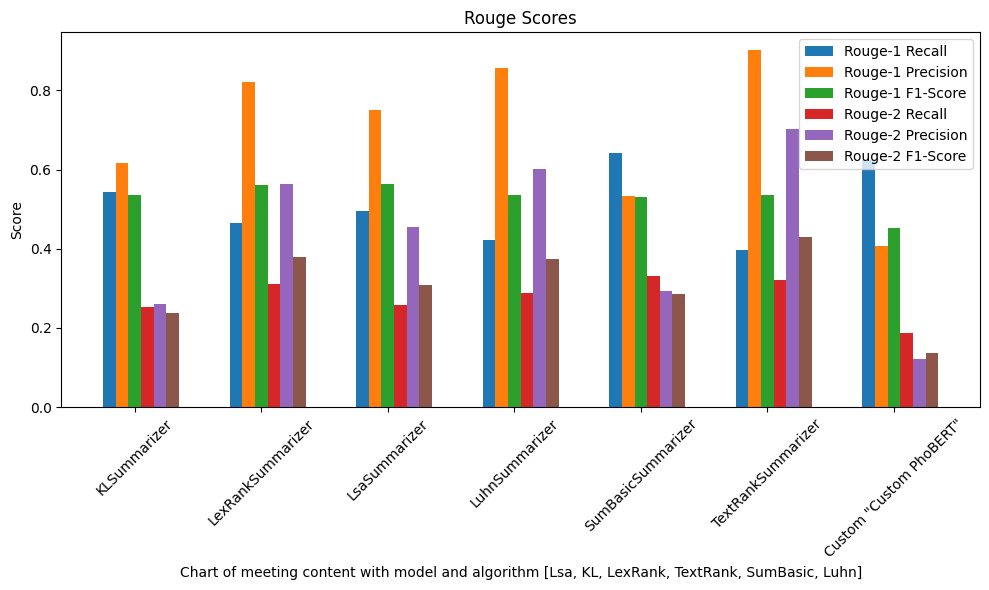

In [ ]:
import matplotlib.pyplot as plt
x = np.arange(len(models))
width = 0.1
plt.figure(figsize=(10, 6))
plt.bar(x, rouge1_recall, width, label='Rouge-1 Recall')
plt.bar(x + width, rouge1_precision, width, label='Rouge-1 Precision')
plt.bar(x + 2 * width, rouge1_f1, width, label='Rouge-1 F1-Score')
plt.bar(x + 3 * width, rouge2_recall, width, label='Rouge-2 Recall')
plt.bar(x + 4 * width, rouge2_precision, width, label='Rouge-2 Precision')
plt.bar(x + 5 * width, rouge2_f1, width, label='Rouge-2 F1-Score')
plt.xlabel('Chart of meeting content with model and algorithm [Lsa, KL, LexRank, TextRank, SumBasic, Luhn]')
plt.ylabel('Score')
plt.title('Rouge Scores')
plt.xticks(x + 2 * width, models, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def getRougeTask(rouge):
  for key,value in rouge.items():
      if key == "rouge1":
         rouge1_recall_task.append(value.mid[0])
         rouge1_precision_task.append(value.mid[1])
         rouge1_f1_task.append(value.mid[2])
         print('rouge1:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])
      elif key == "rouge2":
         rouge2_recall_task.append(value.mid[0])
         rouge2_precision_task.append(value.mid[1])
         rouge2_f1_task.append(value.mid[2])
         print('rouge2:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])
      elif key == "rougeL":
         rougel_recall.append(value.mid[0])
         rougel_precision.append(value.mid[1])
         rougel_f1.append(value.mid[2])
         print('rougeL:recall', value.mid[0],"-precision",value.mid[1],'-F1-Score',value.mid[2])

In [ ]:
rouge1_recall_task = []
rouge1_precision_task = []
rouge1_f1_task = []
rouge2_recall_task = []
rouge2_precision_task = []
rouge2_f1_task = []
models_task = ["People in task (Vncorenlp)","People in task (Custom PhoBERT)", "Content in task", "Time in task"]

print ("rouge_task_result_people")
getRougeTask(rouge_task_result_people)

print ("rouge_task_result_people_new")
getRougeTask(rouge_task_result_people_new)

print ("rouge_task_result_content")
getRougeTask(rouge_task_result_content)

print ("rouge_task_result_time")
getRougeTask(rouge_task_result_time)

rouge_task_result_people
rouge1:recall 0.7490384615384615 -precision 0.7357142857142857 -F1-Score 0.7065448393196072
rouge2:recall 0.5425 -precision 0.5475000000000001 -F1-Score 0.5125505866682337
rougeL:recall 0.7305555555555555 -precision 0.7220238095238096 -F1-Score 0.6924940371805698
rouge_task_result_people_new
rouge1:recall 0.9222222222222222 -precision 0.8603174603174603 -F1-Score 0.8585858585858585
rouge2:recall 0.8930555555555555 -precision 0.7958333333333334 -F1-Score 0.7958760683760684
rougeL:recall 0.918888888888889 -precision 0.8484126984126984 -F1-Score 0.8530303030303031
rouge_task_result_content
rouge1:recall 0.7295485024833928 -precision 0.9000879173460367 -F1-Score 0.7720911725973867
rouge2:recall 0.664100151160467 -precision 0.8380951352029711 -F1-Score 0.7089332798036261
rougeL:recall 0.6609471658292483 -precision 0.842273606795251 -F1-Score 0.7119785032909125
rouge_task_result_time
rouge1:recall 0.9916666666666668 -precision 0.9708333333333332 -F1-Score 0.981547619

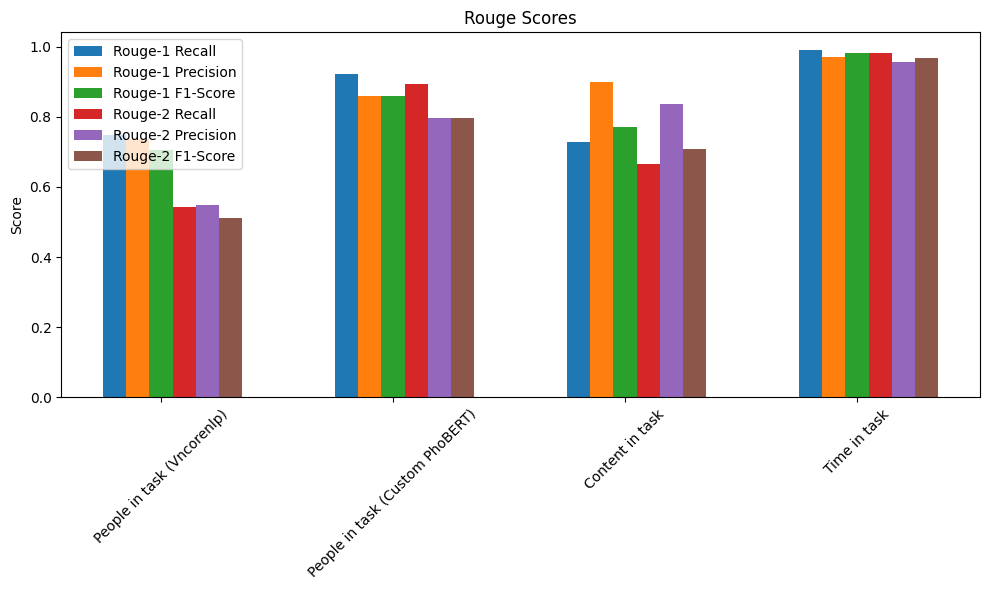

In [ ]:

import matplotlib.pyplot as plt
x = np.arange(len(models_task))
width = 0.1
plt.figure(figsize=(10, 6))
plt.bar(x, rouge1_recall_task, width, label='Rouge-1 Recall')
plt.bar(x + width, rouge1_precision_task, width, label='Rouge-1 Precision')
plt.bar(x + 2 * width, rouge1_f1_task, width, label='Rouge-1 F1-Score')
plt.bar(x + 3 * width, rouge2_recall_task, width, label='Rouge-2 Recall')
plt.bar(x + 4 * width, rouge2_precision_task, width, label='Rouge-2 Precision')
plt.bar(x + 5 * width, rouge2_f1_task, width, label='Rouge-2 F1-Score')
plt.xlabel('')
plt.ylabel('Score')
plt.title('Rouge Scores')
plt.xticks(x + 2 * width, models_task, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()